In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pathlib
import gc

import os.path

In [2]:
dataset_source = 'ADNI'
# the index of the model to test. -1 indicates all models
model_to_test = -1 
# whether to start training from where we left off last time
load_prev_models = False
# number of epochs to train
epochs = 50

# binary classification
class_names = ['NonDemented', 'Demented']
# 2 classes
num_classes = len(class_names)
batch_size = 64
# use the original image size (176x208), with RGB color channels (3)
if dataset_source == 'Kaggle':
    input_shape = (176, 208, 3)
    models_dir = './saved models/'
else:
    input_shape = (224, 224, 3)
    models_dir = './saved models_adni/'
    
models = []
_model_names = ["VGG19 Transfer", "Convolutional Neural Network", "ResNet50 Transfer"]

# pick the models to train based on the `model_to_test` switch value
model_names = []

# -1 means all models
if model_to_test == -1:
    model_names = _model_names
# otherwise, only one specified model gets tested
else:
    model_names.append(_model_names[model_to_test])
print(model_names)

# directory to save the models under (folder doesn't need to be present; the code will create one if it doesn't exist)



['VGG19 Transfer', 'Convolutional Neural Network', 'ResNet50 Transfer']


In [3]:
# the paths to load the data from

if dataset_source == 'Kaggle':
    train_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/train')
    test_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/test')
    # horizontal flip and normalization are on (for better training)
    datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, rescale=1./255)
    # only normalization is on (you don't need to flip test images)
    simple_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # load the training images with horizontal flipping
    train_generator = datagen.flow_from_directory(
            train_dir,
            classes=class_names,
            class_mode='categorical',
            shuffle=True,
            batch_size=batch_size,
            target_size=input_shape[0:2])

    # load the test images just as they are
    test_generator = simple_datagen.flow_from_directory(
            test_dir,
            classes=class_names,
            class_mode='categorical',
            shuffle=True,
            batch_size=batch_size,
            target_size=input_shape[0:2])
    
else:
    data_dir = pathlib.Path('D:/balanced_dataset')
    datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, rescale=1./255, validation_split=0.2)

    # load the training images with horizontal flipping
    train_generator = datagen.flow_from_directory(
            data_dir,
            classes=class_names,
            class_mode='categorical',
            shuffle=True,
            batch_size=batch_size,
            target_size=input_shape[0:2],
            subset='training')

    test_generator = datagen.flow_from_directory(
            data_dir,
            classes=class_names,
            class_mode='categorical',
            shuffle=True,
            batch_size=batch_size,
            target_size=input_shape[0:2],
            subset='validation')


Found 1637 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [4]:
######################## VGG19 ########################
if model_to_test == -1 or model_to_test == 0:
    vgg = keras.applications.VGG19(
            include_top=False,
            input_shape=input_shape,
            pooling=max)
    
    # freeze the whole VGG19 model
    for layer in vgg.layers:
        layer.trainable = False

    #### Create a transfer learning model ####

    transfer_vgg19 = keras.models.Sequential([
            keras.Input(input_shape),
            #layers.GaussianNoise(0.1),
            vgg,
            layers.Flatten(),
            layers.Dropout(0.6),
            layers.BatchNormalization(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes, activation='softmax'),

        ])

    models.append(transfer_vgg19)

In [5]:
#### Create a CNN from scratch ####

if model_to_test == -1 or model_to_test == 1:
    # Gaussian noise -> 5 convolution blocks -> flatten -> 3 dense layers
    cnn = keras.models.Sequential([
            keras.Input(input_shape),
            layers.GaussianNoise(0.15),
            layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
            layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(),

            layers.SeparableConv2D(32, kernel_size=(3,3), activation='relu'),
            layers.SeparableConv2D(32, kernel_size=(3,3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(),

            layers.SeparableConv2D(64, kernel_size=(3,3), activation='relu'),
            layers.SeparableConv2D(64, kernel_size=(3,3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(),

            layers.SeparableConv2D(128, kernel_size=(3,3), activation='relu'),
            layers.SeparableConv2D(128, kernel_size=(3,3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(),

            layers.SeparableConv2D(256, kernel_size=(3,3), activation='relu'),
            layers.SeparableConv2D(256, kernel_size=(3,3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(),

            layers.Flatten(),
            layers.Dense(16, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(16, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(num_classes, activation='softmax'),
        ])

    models.append(cnn)

In [6]:
if model_to_test == -1 or model_to_test == 2:
    input_t = keras.Input(shape=input_shape)
    ResNet = keras.applications.ResNet50(
            include_top=False,
            input_tensor=input_t,
            pooling=max)

    # freeze the whole ResNet50 model
    for layer in ResNet.layers[:]:
        layer.trainable = False

    transfer_resnet = keras.models.Sequential([
        ResNet,
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(2,activation="softmax"),
    ])

    models.append(transfer_resnet)

In [7]:
# print the summary/summaries of the model(s)
for i in range(len(models)):
    print(f"model #{i+1}: {model_names[i]}")
    models[i].summary()
    print("\n\n")

# create a folder to save models if it doesn't exist already
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# load model weights and test them only if the weight files exist and load_prev_models is set to True
for i in range(len(models)):
    model = models[i]
    if load_prev_models and os.path.exists(models_dir + model_names[i] + ".index"):
        model.load_weights(models_dir + model_names[i])
    
    # model should be compiled whether it's blank or loaded, because this is required before you can actually fit the model
    model.compile(loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])
    
    # test accuracy if model has been loaded
    if load_prev_models and os.path.exists(models_dir + model_names[i] + ".index"):
        loss, acc = model.evaluate(test_generator, verbose=0)
        print(f"weights for model #{i+1} ({model_names[i]}) loaded: acc={acc*100}%")

model #1: VGG19 Transfer
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (N

In [8]:
histories = []

keras.backend.clear_session()
gc.collect()

# print the lengthy messages when you're testing one model only. If you're training all of them, better make it silent
if len(models) == 1:
    verbosity = 1
else:
    verbosity = 0
    
# fit and save each model, while saving each model's training history
for i in range(len(models)):
    model = models[i]
    histories.append( model.fit(train_generator, epochs=epochs, validation_data=test_generator, verbose=verbosity) )
    print(f"::::::: model #{len(histories)} training complete :::::::")
    model.save_weights(models_dir + model_names[i])
    print(f":::::::   model #{len(histories)} weights saved   :::::::")

::::::: model #1 training complete :::::::
:::::::   model #1 weights saved   :::::::
::::::: model #2 training complete :::::::
:::::::   model #2 weights saved   :::::::
::::::: model #3 training complete :::::::
:::::::   model #3 weights saved   :::::::


weights for model #1 (VGG19 Transfer) loaded: acc=89.46078419685364%
weights for model #2 (Convolutional Neural Network) loaded: acc=68.8725471496582%
weights for model #3 (ResNet50 Transfer) loaded: acc=59.558820724487305%


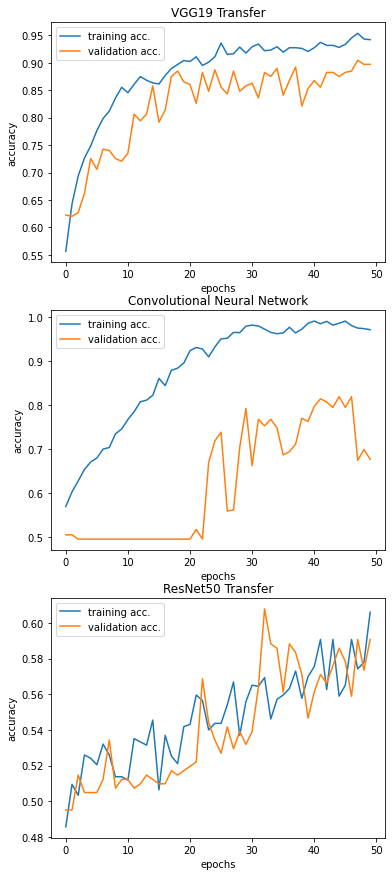

In [9]:
# this one is for a multi-model training result (building subplots); plot accuracy against epoch
if len(histories) > 1:
    fig, axs = plt.subplots( len(histories), figsize=(6,5*len(histories)) )
    for i in range(len(histories)):
        history = histories[i]
        axs[i].plot(history.history['accuracy'], label = "training acc.")
        axs[i].plot(history.history['val_accuracy'], label = "validation acc.")
        axs[i].legend(['training acc.', 'validation acc.'], loc='upper left')
        axs[i].set_title(model_names[i])
    for ax in axs.flat:
        ax.set(xlabel='epochs', ylabel='accuracy')

# this one is for a single-model training result (just one whole plot, virtually the same as the one above)
else:
    history = histories[0]
    plt.plot(history.history['accuracy'], label = "training acc.")
    plt.plot(history.history['val_accuracy'], label = "validation acc.")
    plt.legend(['training acc.', 'validation acc.'], loc='upper left')
    plt.title(model_names[i])

# change the file name to save the plot into a different png
plt.savefig("../Project/Result2/ensemble_model_50_ADNI.png")

# prints the final accuracy/accuracies of the model(s)
for i in range(len(models)):
    model = models[i]
    model.compile(loss="categorical_crossentropy",
        optimizer="adam",
        metrics=['accuracy'])
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"weights for model #{i+1} ({model_names[i]}) loaded: acc={acc*100}%")


In [10]:
# define the ensemble input shape (basically just the image shape (176, 208, 3))
model_input = keras.Input(shape=input_shape)
# a pseudo-ensemble model using keras' Average layer; this is not a true voting system
ensemble_output = layers.Average()([model(model_input) for model in models])
# construct the model
ensemble_model = keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.summary()

# since the constituent models are already trained, all we need to do is evaluate it
ensemble_model.compile(loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"])
loss, acc = ensemble_model.evaluate(test_generator, verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2)            33055298    input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            180066      input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2)            23877922    input_1[0][0]                    
______________________________________________________________________________________________